In [1]:
import os
os.chdir('/Users/nico/Desktop/Github')
print(os.getcwd())

/Users/nico/Desktop/Github


In [2]:
import pandas as pd

df = pd.read_csv('sarcasm_detection/data/corpora_sarcastic_merged.csv')

df.head()

,titles,Label
0,"Trentino, femministe chiedono l'abbattimento d...",1
1,"""Voglio essere come lui!"" Bambino guarda video...",1
2,"""Vorrei staccare la spina"". Sospeso medico ria...",1
3,"Gatta muore al pronto soccorso per animali, ve...",1
4,"Bologna, Comune installa sui semafori piccioni...",1


In [3]:
from sklearn.model_selection import train_test_split

train_texts, temp_texts, train_labels, temp_labels = train_test_split(df['titles'], df['Label'], test_size=0.2, random_state=42)

val_texts, test_texts, val_labels, test_labels = train_test_split(temp_texts, temp_labels, test_size=0.5, random_state=42)

In [4]:
pip install sentencepiece

Note: you may need to restart the kernel to use updated packages.


In [6]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model_name = 'distilbert/distilbert-base-multilingual-cased'

# tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Tokenize the texts
train_encodings = tokenizer(train_texts.tolist(), truncation=True, padding=True)

val_encodings = tokenizer(val_texts.tolist(), truncation=True, padding=True)

test_encodings = tokenizer(test_texts.tolist(), truncation=True, padding=True)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

In [7]:
import torch

# define a PyTorch dataset

class SarcasmDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
         self.encodings = encodings
         self.labels = labels
        
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx]) 
        return item
        
    def __len__(self):
        return len(self.labels)

In [8]:
# convert our tokenized data into a torch datasets
train_dataset = SarcasmDataset(train_encodings, train_labels.tolist())
val_dataset = SarcasmDataset(val_encodings, val_labels.tolist())
test_dataset = SarcasmDataset(test_encodings, test_labels.tolist())

In [9]:
model = AutoModelForSequenceClassification.from_pretrained(model_name)  # num_labels=2 for binary classification

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


model.safetensors:   0%|          | 0.00/542M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
from transformers import Trainer, TrainingArguments

# training arguments
training_args = TrainingArguments(
    output_dir='./outputs',
    num_train_epochs=1,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    warmup_steps=100,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_strategy='steps',
    logging_steps=25,
    evaluation_strategy='steps',
    save_steps=50,
    eval_steps=50,
    load_best_model_at_end=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

In [11]:
trainer.train()

Step,Training Loss,Validation Loss
50,0.492800,0.215988
100,0.093300,0.092299
150,0.148100,0.074753
200,0.055800,0.053083
250,0.033900,0.061952
300,0.027100,0.036289
350,0.032000,0.036991
400,0.016700,0.036554


TrainOutput(global_step=413, training_loss=0.1294170205298694, metrics={'train_runtime': 434.678, 'train_samples_per_second': 30.404, 'train_steps_per_second': 0.95, 'total_flos': 191481624757248.0, 'train_loss': 0.1294170205298694, 'epoch': 1.0})

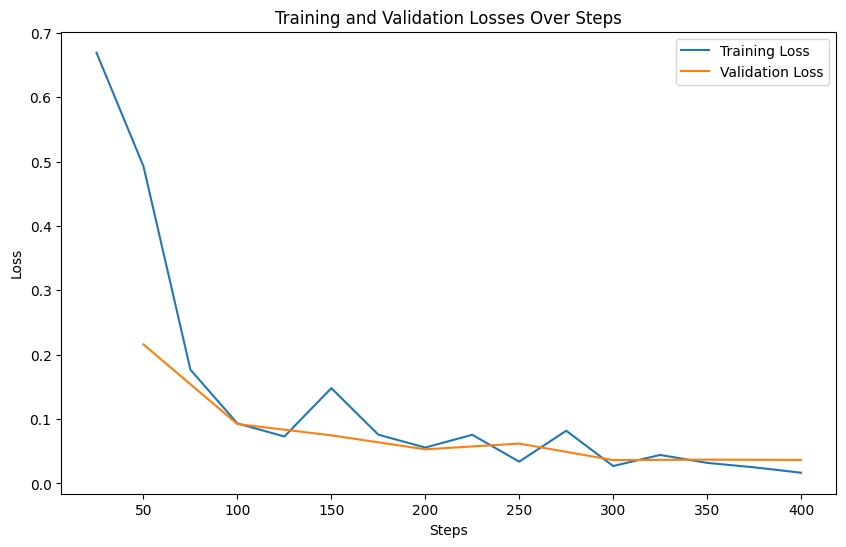

In [12]:
import matplotlib.pyplot as plt

train_stats = trainer.state.log_history

train_loss = [x['loss'] for x in train_stats if 'loss' in x]
eval_loss = [x['eval_loss'] for x in train_stats if 'eval_loss' in x]

train_steps = [x['step'] for x in train_stats if 'loss' in x]
eval_steps = [x['step'] for x in train_stats if 'eval_loss' in x]

plt.figure(figsize=(10, 6))
plt.plot(train_steps, train_loss, label='Training Loss')
plt.plot(eval_steps, eval_loss, label='Validation Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Losses Over Steps')
plt.show()

In [ ]:
import numpy as np

# Evaluate the model
eval_results = trainer.evaluate(test_dataset)

# Print evaluation results
print(eval_results)

# Predict on new data
predictions = trainer.predict(test_dataset)

# The predictions are in logits. Convert them to class labels.
predicted_labels = np.argmax(predictions.predictions, axis=1)

print(predicted_labels)

{'eval_loss': 0.039880987256765366, 'eval_runtime': 8.568, 'eval_samples_per_second': 192.928, 'eval_steps_per_second': 3.035, 'epoch': 1.0}


### here i build a test set composed by the real labels and the predictions in order to visually compare the pred. results 

In [22]:
df_pred = pd.DataFrame({
    'titles': test_texts,
    'Label': test_labels
})

df_pred['predictions'] = predicted_labels

df_pred.head()

,titles,Label,predictions
10359,Alcune multinazionali dell’energia stanno anda...,0,0
3886,Chiara Ferragni lancia la sua linea di Green Pass,1,1
2129,"Inchiesta shock di Repubblica: ""Perché anche i...",1,1
16443,“Zombie” dei Cranberries alla Coppa del Mondo ...,0,0
7313,I partitini di centro non smettono di contende...,0,0


In [23]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

def evaluate_predictions(df):
    errors = df[df['Label'] != df['predictions']]
    num_errors = len(errors)
    
    print(f"\nNumber of errors: {num_errors}\n")
    
    accuracy = accuracy_score(df['Label'], df['predictions'])
    f1 = f1_score(df['Label'], df['predictions'])
    precision = precision_score(df['Label'], df['predictions'])
    recall = recall_score(df['Label'], df['predictions'])

    print(f"Accuracy: {accuracy}")
    print(f"F1 Score: {f1}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}\n")

    print("Misclassified titles:\n")
    for index, row in errors.iterrows():
        label = "sarcastic" if row['Label'] == 1 else "not sarcastic"
        prediction = "sarcastic" if row['predictions'] == 1 else "not sarcastic"
        print(f"Title: {row['titles']}, Label: {label}, Prediction: {prediction}")


In [24]:
evaluate_predictions(df_pred)


Number of errors: 40

Accuracy: 0.9758015728977616
F1 Score: 0.9659284497444633
Precision: 0.9759036144578314
Recall: 0.9561551433389545

Misclassified titles:

Title: STRAMACCIONI PERDE L’ENNESIMA PARTITA E VIENE NOMINATO SEGRETARIO DEL PD, Label: sarcastic, Prediction: not sarcastic
Title: Cioè, un vecchio giornale per giovanissime, Label: not sarcastic, Prediction: sarcastic
Title: Fortunato Ortombina sarà nominato sovrintendente della Scala di Milano, Label: not sarcastic, Prediction: sarcastic
Title: CONTRO STRAGI NELLE SCUOLE, CAMPI DI CONCENTRAMENTO PER ADOLESCENTI TIMIDI, Label: sarcastic, Prediction: not sarcastic
Title: Te lo puntella mentre dormi? Da oggi puoi chiedere il divorzio, Label: sarcastic, Prediction: not sarcastic
Title: È DICK CHENEY IL CACCIATORE CHE UCCISE LA MADRE DI BAMBI, Label: sarcastic, Prediction: not sarcastic
Title: Il ministro Kyenge si dimette, al suo posto Burzum, Label: sarcastic, Prediction: not sarcastic
Title: Avvistato velivolo all’aeroporto d

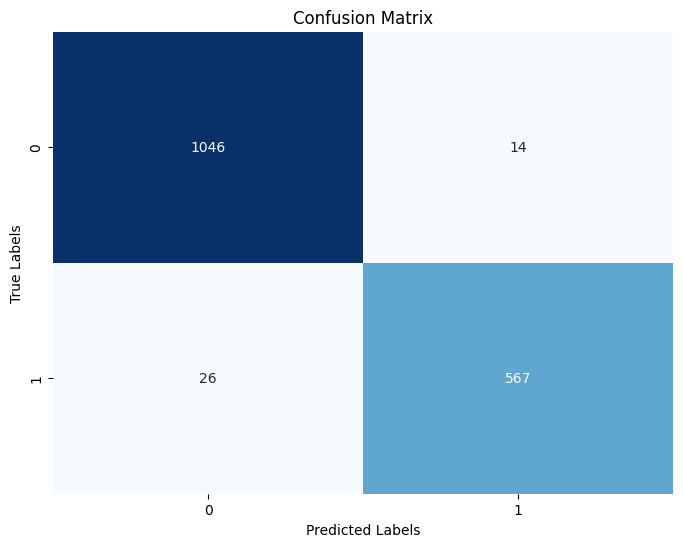

In [25]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

true_labels = df_pred['Label']
predicted_labels = df_pred['predictions']

conf_matrix = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

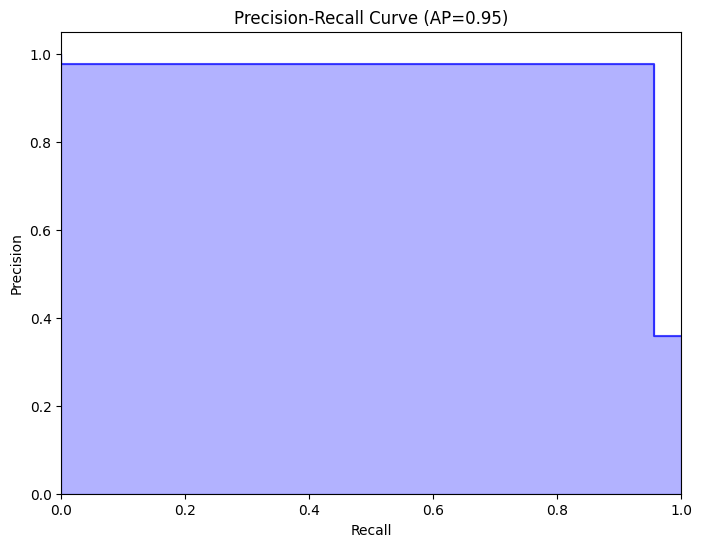

In [26]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

precision, recall, _ = precision_recall_curve(true_labels, predicted_labels)
average_precision = average_precision_score(true_labels, predicted_labels)

# Plot precision-recall curve
plt.figure(figsize=(8, 6))
plt.step(recall, precision, color='b', alpha=0.7, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.3, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve (AP={0:0.2f})'.format(average_precision))
plt.show()

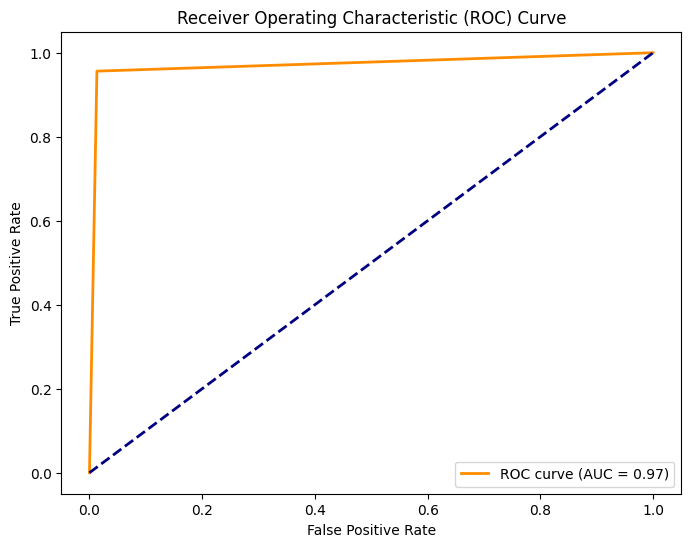

In [27]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(true_labels, predicted_labels)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


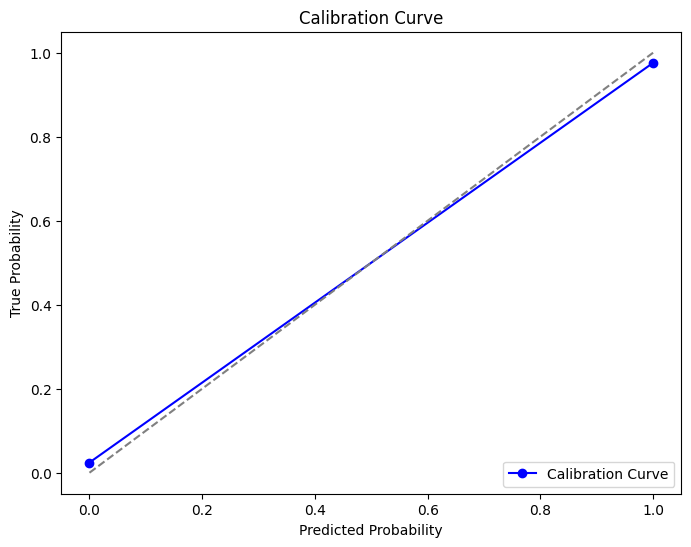

In [28]:
from sklearn.calibration import calibration_curve

prob_true, prob_pred = calibration_curve(true_labels, predicted_labels, n_bins=10)

plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Calibration Curve', color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('Predicted Probability')
plt.ylabel('True Probability')
plt.title('Calibration Curve')
plt.legend(loc='lower right')
plt.show()